In [13]:
import numpy as np
from scipy import fftpack
from PIL import Image
import matplotlib.pyplot as plt
# Nếu cần thì bạn cũng có thể import các thư viện khác ...

In [2]:
def dct2(pixels):
    '''
    Hàm biến đổi từ ma trận điểm ảnh sang ma trận hệ số DCT (2 ma trận có cùng shape).
    '''
    return fftpack.dct(fftpack.dct(pixels, axis=0, norm='ortho'), axis=1, norm='ortho')

def idct2(dct_coefs):
    '''
    Hàm biến đổi từ ma trận hệ số DCT sang ma trận điểm ảnh (2 ma trận có cùng shape).
    '''
    return fftpack.idct(fftpack.idct(dct_coefs, axis=0 , norm='ortho'), axis=1, norm='ortho')

In [14]:
def embed(watermark, original_img_file, alpha, marked_img_file):
    '''
    Nhúng watermark vào ảnh bằng phương pháp Cox.
    
    Các tham số:
        watermark (mảng numpy một chiều): Watermark sẽ nhúng vào ảnh.
        original_img_file (str): Tên file ảnh gốc (chưa nhúng watermark).
        alpha (float, > 0): Tham số điều khiển mức độ làm thay đổi ảnh của watermark.
        marked_img_file (str): Tên file ảnh chứa kết quả nhúng.       
    '''
    # Đọc original img file
    original_pixels = np.array(Image.open(original_img_file))
    
    # Biến đổi DCT
    dct_coefs = dct2(original_pixels).reshape(-1)
    
    # Nhúng watermark vào các hệ số DCT lớn nhất
    temp = np.argsort(dct_coefs)
    dct_coefs[temp[-len(watermark):]] *= (1 + alpha * watermark)
    
    # Biến đổi DCT ngược
    dct_coefs = dct_coefs.reshape(original_pixels.shape)
    marked_pixels = np.rint(idct2(dct_coefs)).astype(np.uint8)

    # Ghi marked pixels xuống file
    Image.fromarray(marked_pixels).save(marked_img_file)

In [8]:
def check_watermark(watermark, img_file, original_img_file, alpha):
    '''
    Kiểm tra xem có watermark trong ảnh không?
    
    Các tham số:
        watermark (mảng numpy một chiều): Watermark cần kiểm tra.
        img_file (str): Tên file ảnh cần kiểm tra.
        original_img_file (str): Tên file ảnh gốc (chưa nhúng watermark).
        alpha (float, > 0): Tham số điều khiển mức độ làm thay đổi ảnh của watermark;
                            tham số này đã được sử dụng khi nhúng.
    Giá trị trả về:
        float: Độ tương tự giữa watermark được rút trích với watermark gốc.
    '''
    # Đọc img file và original img file
    pixels = np.array(Image.open(img_file))
    original_pixels = np.array(Image.open(original_img_file))
    
    # Biến đổi DCT
    dct_coefs = dct2(pixels).reshape(-1)
    original_dct_coefs = dct2(original_pixels).reshape(-1)
    
    # Rút trích watermark
    temp = np.argsort(original_dct_coefs)
    n = len(watermark)
    extr_watermark = (dct_coefs[temp[-n:]] - original_dct_coefs[temp[-n:]]) / (alpha * original_dct_coefs[temp[-n:]])
    
    # Tính độ tương tự giữa watermark rút trích được và watermark cần kiểm tra
    similarity = np.sum(extr_watermark * watermark) / np.sqrt(np.sum(extr_watermark * extr_watermark))
    return similarity

In [4]:
# Tạo ra 100 watermark
# Mỗi watermark gồm 1000 phần tử
# Mỗi phần tử được phát sinh ngẫu nhiên từ phân bố Gauss có mean = 0, variance = 1
watermarks = np.random.randn(100, 1000)

In [7]:
# Chọn một watermark để nhúng vào ảnh
# Chẳng hạn, chọn watermark thứ 20 (chỉ số 19)
watermark = watermarks[19]
alpha = 0.1
embed(watermark, '10-lena.bmp', alpha, '10-marked_lena.bmp')

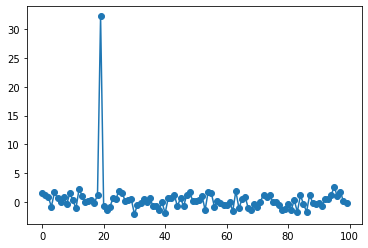

In [9]:
# Với mỗi watermark trong 100 watermark, kiểm xem có trong ảnh đã được nhúng không
similarities = []
for i in range(len(watermarks)):
    similarity = check_watermark(watermarks[i], '10-marked_lena.bmp', '10-lena.bmp', alpha)
    similarities.append(similarity)
plt.plot(similarities, 'o-')

In [10]:
# Nén JPEG
img = Image.open('10-marked_lena.bmp')
img.save('10-marked_lena.jpg', quality=10)
img.close()

# Watermark có còn?
check_watermark(watermark, '10-marked_lena.jpg', '10-lena.bmp', alpha)

19.058030226665707

In [11]:
# Thu nhỏ ảnh & phóng to lên lại
img = Image.open('10-marked_lena.bmp')
down_img = img.resize((int(img.width / 2), int(img.height / 2)))
down_up_img = down_img.resize((img.width, img.height))
down_up_img.save('10-down_up_marked_lena.bmp')
img.close()

# Watermark có còn?
check_watermark(watermark, '10-down_up_marked_lena.bmp', '10-lena.bmp', alpha)

19.54849060602123

In [12]:
# Crop ảnh, rồi tạo ảnh hoàn chỉnh (để có thể check watermark) 
# bằng cách thêm vào các phần của ảnh ban đầu (ko có watermark)
img = Image.open('10-marked_lena.bmp')
left = int(img.width / 4); upper = int(img.height / 4)
right = int(img.width / 4 * 3); lower = int(img.height / 4 * 3)
crop_img = np.array(img.crop((left, upper, right, lower)))
uncrop_crop_img = np.array(Image.open('10-lena.bmp'))
uncrop_crop_img[upper:lower, left:right] = crop_img
Image.fromarray(uncrop_crop_img).save('10-uncrop_crop_marked_lena.bmp')

# Watermark có còn?
check_watermark(watermark, '10-uncrop_crop_marked_lena.bmp', '10-lena.bmp', alpha)

13.834077027882467